In [1]:
%matplotlib inline

In [2]:
import pathlib
import shutil
from datetime import datetime

In [3]:
import xarray as xr

In [4]:
import pandas as pd

### reads the data in using pandas 

In [5]:
filename = pathlib.Path('TS_NZ_region_NNI_TMEAN_3_quantiles_anoms.csv')

In [6]:
fname_in = pathlib.Path.cwd().joinpath(filename)

In [7]:
data = pd.read_csv(fname_in, index_col=0, parse_dates=True)

In [8]:
data.head()

,Tmean,cat_3,anomalies
time,,,
1979-03-31,18.334898,3,0.465166
1979-04-30,16.843733,2,0.216447
1979-05-31,14.747330,2,0.276076
1979-06-30,12.155292,2,0.014663
1979-07-31,10.388794,2,0.012815


### casts into an xarray 

In [9]:
data_nc = data.to_xarray()

In [10]:
data_nc.dims

Frozen(SortedKeysDict({'time': 490}))

In [11]:
data_nc.data_vars

Data variables:
    Tmean      (time) float64 18.33 16.84 14.75 12.16 ... 11.48 13.49 15.52
    cat_3      (time) int64 3 2 2 2 2 2 2 2 2 2 2 1 ... 3 3 3 3 3 2 3 3 3 3 3 3
    anomalies  (time) float64 0.4652 0.2164 0.2761 ... 0.1995 0.5849 0.8152

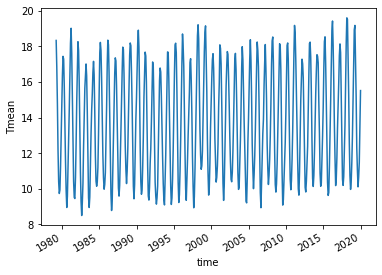

In [12]:
data_nc['Tmean'].plot()

### you can easily add attributes 

### global attributes 

In [13]:
data_nc.attrs['author'] = 'Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz'
data_nc.attrs['description'] = 'seasonal anomalies and tercile categories for the NNI'
data_nc.attrs['history'] = f'saved on {datetime.utcnow():%Y-%m-%d}'

In [14]:
data_nc.attrs

{'author': 'Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz',
 'description': 'seasonal anomalies and tercile categories for the NNI',
 'history': 'saved on 2020-08-31'}

### and variable specific attributes 

In [15]:
data_nc['Tmean'].attrs['description'] = 'Mean temperature'
data_nc['Tmean'].attrs['units'] = 'degrees C'
data_nc['Tmean'].attrs['valid_range'] = [0,30]

data_nc['cat_3'].attrs['description'] = 'Category (1=below, 2=normal, 3=above)'
data_nc['cat_3'].attrs['units'] = 'unitless'
data_nc['cat_3'].attrs['valid_range'] = [1,3]

data_nc['anomalies'].attrs['description'] = 'Temperature anomalies'
data_nc['anomalies'].attrs['units'] = 'degrees C'
data_nc['anomalies'].attrs['valid_range'] = [-10,10]

### the unit will automatically be added to the plot for example (y-axis label)

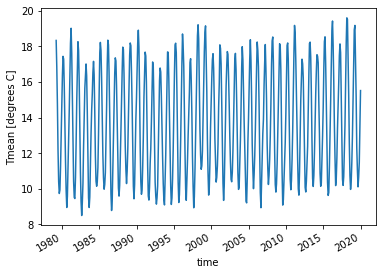

In [16]:
data_nc['Tmean'].plot()

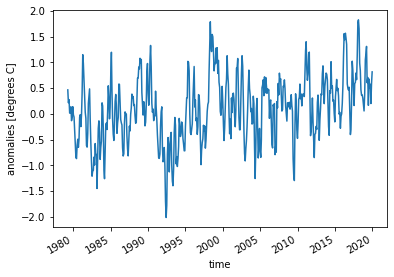

In [17]:
data_nc['anomalies'].plot()

### saves in netcdf (now with the attributes)

In [18]:
data_nc.to_netcdf(fname_in.with_suffix('.nc')) 

### saves in ZARR 

In [19]:
if (fname_in.with_suffix('.zarr')).exists():
    shutil.rmtree(fname_in.with_suffix('.zarr'))

In [20]:
data_nc.to_zarr(fname_in.with_suffix('.zarr'))

### Now reads it back 

In [21]:
dset = xr.open_dataset('./TS_NZ_region_NNI_TMEAN_3_quantiles_anoms.nc')

In [22]:
dset

<xarray.Dataset>
Dimensions:    (time: 490)
Coordinates:
  * time       (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
Data variables:
    Tmean      (time) float64 ...
    cat_3      (time) int64 ...
    anomalies  (time) float64 ...
Attributes:
    author:       Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz
    description:  seasonal anomalies and tercile categories for the NNI
    history:      saved on 2020-08-31

In [23]:
dset.attrs

{'author': 'Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz',
 'description': 'seasonal anomalies and tercile categories for the NNI',
 'history': 'saved on 2020-08-31'}

### can get the global attributes as a Series (global attributes) or a dataframe (attributes of the data variables)

In [24]:
pd.Series(dset.attrs)

author         Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz
description    seasonal anomalies and tercile categories for ...
history                                      saved on 2020-08-31
dtype: object

In [25]:
dvars = {}
for varname, da in dset.data_vars.items():
    print(f"{varname} {da.attrs}")
    dvars[varname] = da.attrs

Tmean {'description': 'Mean temperature', 'units': 'degrees C', 'valid_range': array([ 0, 30])}
cat_3 {'description': 'Category (1=below, 2=normal, 3=above)', 'units': 'unitless', 'valid_range': array([1, 3])}
anomalies {'description': 'Temperature anomalies', 'units': 'degrees C', 'valid_range': array([-10,  10])}


In [26]:
pd.DataFrame(dvars)

,Tmean,cat_3,anomalies
description,Mean temperature,"Category (1=below, 2=normal, 3=above)",Temperature anomalies
units,degrees C,unitless,degrees C
valid_range,"[0, 30]","[1, 3]","[-10, 10]"


### select a period range

In [27]:
dset = dset.sel(time=slice('1981','2010')) 

### selects a variable 

In [28]:
dset = dset[['anomalies']]

In [29]:
dset

<xarray.Dataset>
Dimensions:    (time: 360)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2010-12-31
Data variables:
    anomalies  (time) float64 -0.005437 0.3906 1.15 ... 0.3777 0.3362 0.7992
Attributes:
    author:       Nicolas Fauchereau <nicolas.fauchereau@niwa.co.nz
    description:  seasonal anomalies and tercile categories for the NNI
    history:      saved on 2020-08-31

### then back to a DataFrame 

In [30]:
df = dset.to_dataframe()

In [31]:
df

,anomalies
time,
1981-01-31,-0.005437
1981-02-28,0.390589
1981-03-31,1.150252
1981-04-30,0.984453
1981-05-31,0.672184
...,...
2010-08-31,0.346205
2010-09-30,0.386330
2010-10-31,0.377686
